In [97]:
import pandas as pd
import requests
import time
import datetime
from datetime import datetime as dt
from tqdm.notebook import tqdm

# bithumb api 호출

In [98]:
url = 'https://api.bithumb.com/public/ticker/all'
params = '{order_currency}_{payment_currency}/{chart_intervals}'
resp = requests.get(url)
coin_list = list(resp.json()['data'].keys())[:-1]
df_list = list(map(lambda i: 'df_' + i, coin_list))
df_coin_dict = {}

In [99]:
to_dt = lambda i: dt.fromtimestamp(i/1000)
def get_dist(df):
    return abs(df['ma90']- df['ma45'])
def get_voldist(df):
    return abs(df['volMA90']- df['volMA45'])

In [116]:
for coin in tqdm(coin_list):
    # crawling part
    chart_intervals = ''
    payment_currency = 'KRW'
    order_currency = coin
    url = f'https://api.bithumb.com/public/candlestick/{order_currency}_{payment_currency}/{chart_intervals}'
    resp = requests.get(url)
    json_coin = resp.json()['data']
    # json to df
    df_coin = pd.DataFrame.from_dict(json_coin)
    df_coin.columns = ['datetime','open','close','high','low','volume']
    df_coin['datetime'] = df_coin['datetime'].apply(to_dt)
    df_coin.set_index('datetime', inplace=True)
    df_coin['open'] = df_coin['open'].astype('float')
    df_coin['close'] = df_coin['close'].astype('float')
    df_coin['high'] = df_coin['high'].astype('float')
    df_coin['low'] = df_coin['low'].astype('float')
    df_coin['volume'] = df_coin['volume'].astype('float')
    # 주가 변동폭 계산
    df_coin['diff'] = df_coin['high'] - df_coin['low']    
    # 이평 이격도 계산
    df_coin['ma90'] = df_coin['close'].rolling(window=90, min_periods=90).mean()
    df_coin['ma45'] = df_coin['close'].rolling(window=45, min_periods=45).mean()
    df_coin['dist'] = df_coin.apply(get_dist, axis=1)
    # 거래량 비율 계산
    df_coin['volMA90'] = df_coin['volume'].rolling(window=90, min_periods=90).mean()
    df_coin['volMA45'] = df_coin['volume'].rolling(window=45, min_periods=45).mean()
    df_coin['voldist'] = df_coin.apply(get_voldist, axis=1)
    df_coin['volRatio'] = abs(1 - df_coin['volume'] / df_coin['volMA90'])
    # 볼린저 밴드 계산
    df_coin['mbb'] = df_coin['close'].rolling(90).mean()
    df_coin['ubb'] = df_coin['mbb'] + 2 * df_coin['close'].rolling(60).std()
    df_coin['lbb'] = df_coin['mbb'] - 2 * df_coin['close'].rolling(60).std()
    df_coin['bolingerdiff'] = df_coin['ubb'] - df_coin['lbb']
    df_coin_dict[coin] = df_coin
# 시간 시 종 고 저 거래량

In [101]:
df_BTC = df_coin_dict['BTC']

# 주가 변동폭

In [ ]:
# df_BTC['diff'] = df_BTC['high'] - df_BTC['low']    

# macd(deprecated)

In [12]:
# def get_macd(df):
#     df['ma12'] = df.close.ewm(span=12).mean() # 단기(12) EMA(지수이동평균) 
#     df['ma26'] = df.close.ewm(span=26).mean() # 장기(26) EMA 
#     df['macd'] = df['ma12'] - df['ma26'] # MACD 
#     df['sig'] = df['macd'].ewm(span=9).mean() # Signal 
#     df['osc'] = df['macd'] - df['sig'] # Oscillator

In [13]:
# get_macd(df_BTC)

# 볼린저 밴드

In [ ]:
# df_BTC['mbb'] = df_BTC['close'].rolling(20).mean()
# df_BTC['ubb'] = mbb + 2 * df_BTC['close'].rolling(20).std()
# df_BTC['lbb'] = mbb - 2 * df_BTC['close'].rolling(20).std()
# df_BTC['bolingerdiff'] = df_BTC['ubb'] - df_BTC['lbb']

# 거래량 비율

In [31]:
# df_BTC['volMA90'] = df_BTC['volume'].rolling(window=90, min_periods=90).mean()
# df_BTC['volRatio'] = df_BTC['volume'] / df_BTC['volMA90']

# 90일간 변동폭

In [117]:
df_XSR = df_coin_dict['XSR']

In [118]:
df_XSR['preboldiff'] = df_XSR['bolingerdiff'].shift(1)
df_XSR['boldiffratio'] = (df_XSR['bolingerdiff'] - df_XSR['preboldiff']) / df_XSR['preboldiff'] * 100

In [120]:
df_XSR['boldiffratio']['2020-03-01':'2020-05-01']

datetime
2020-03-01   -5.278364
2020-03-02   -5.403522
2020-03-03   -5.063421
2020-03-04   -6.274180
2020-03-05   -6.650976
                ...   
2020-04-27   -2.534925
2020-04-28   -3.448477
2020-04-29   -3.946271
2020-04-30   -5.469519
2020-05-01   -5.424642
Name: boldiffratio, Length: 62, dtype: float64

# 상관계수

In [102]:
df_BTC.corr()['diff'].sort_values(ascending=False)

diff            1.000000
bolingerdiff    0.771597
ubb             0.701375
dist            0.696433
high            0.695303
open            0.669563
close           0.665226
mbb             0.649314
low             0.635072
ma45            0.612271
lbb             0.556575
ma90            0.530111
volMA90         0.516306
volMA45         0.505428
volume          0.490018
voldist         0.318136
volRatio        0.200772
Name: diff, dtype: float64

# 지금 알고싶은것  
## 기어가는 종목 = 90일(가정)간 변동폭이 일정한 종목  
# 기준 날짜 = 90일  
# 유력 후보  
## dist = 90이평 - 45이평간 거리
## bolingerdiff = 볼린저밴드 상하 거리
## volume = 거래량

# 데이터 전처리

In [ ]:
from sklearn.preprocessing import StandardScaler

In [29]:
scaler = StandardScaler()
scaler.fit(df_BTC)
BTC_scaled = scaler.transform(df_BTC)

In [33]:
BTC_df_scaled = pd.DataFrame(data=BTC_scaled, columns=df_BTC.columns)
BTC_df_scaled[180:].head()

,open,close,high,low,volume,diff,ma90,ma45,dist,volMA90,volMA45,voldist,volRatio,mbb,ubb,lbb,bolingerdiff
180,-0.840885,-0.840510,-0.836285,-0.842978,-0.647717,-0.497556,-0.890048,-0.857175,-0.527378,-0.936436,-0.811116,-0.531732,-0.215827,-0.847173,-0.832137,-0.842631,-0.586800
181,-0.839834,-0.841561,-0.836488,-0.843196,-0.574008,-0.497556,-0.889875,-0.856437,-0.524359,-0.935866,-0.808616,-0.526452,1.102985,-0.847534,-0.833239,-0.841941,-0.590832
182,-0.840885,-0.844922,-0.837907,-0.848205,-0.526386,-0.466500,-0.889713,-0.855757,-0.521594,-0.933805,-0.805008,-0.521815,2.575853,-0.848054,-0.834516,-0.841382,-0.595073
183,-0.844249,-0.851436,-0.840744,-0.858007,-0.493725,-0.406328,-0.889530,-0.855240,-0.519793,-0.931319,-0.800239,-0.515115,3.436162,-0.848733,-0.833910,-0.843843,-0.589101
184,-0.850975,-0.861102,-0.846824,-0.864977,-0.523755,-0.402446,-0.889432,-0.854991,-0.518981,-0.929640,-0.796522,-0.509267,2.356601,-0.849847,-0.831273,-0.850190,-0.570982


# 선형회귀분석

In [7]:
import statsmodels.formula.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [34]:
result = sm.ols(formula= '''diff ~ bolingerdiff + dist + 
                volume + ubb + high + open + close +
                mbb + low + ma45 + lbb + ma90 + volMA90 + 
                volMA45 + voldist + volRatio
                ''', data= BTC_df_scaled).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.671e+31
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:25:35   Log-Likelihood:                 71096.
No. Observations:                2223   AIC:                        -1.422e+05
Df Residuals:                    2208   BIC:                        -1.421e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.372e-15   6.67e-17    -20.558      0.000    -1.5e-15   -1.24e-15
bolingerdiff  4.982e-15   1.35e-16     36.931      0.000    4.72e-15    5.25e-15
dist         -1.965e-15   1.33e-16    -14.757      0.000   -2.23e-15    -1.7e-15
volume       -2.706e-16   1.14e-16     -2.374      0.018   -4.94e-16   -4.71e-17
ubb          -1.185e-14    2.5e-16    -47.458      0.000   -1.23e-14   -1.14e-14
high             9.5776   2.42e-15   3.96e+15      0.000       9.578       9.578
open          4.885e-15   1.99e-15      2.458      0.014    9.87e-16    8.78e-15
close        -9.326e-15   2.53e-15     -3.687      0.000   -1.43e-14   -4.37e-15
mbb           1.624e-15   2.79e-16      5.821      0.000    1.08e-15    2.17e-15
low             -8.9113   2.18e-15  -4.09e+15      0.000      -8.911      -8.911
ma45          4.968e-15   7.88e-16      6.308      0.000    3.42e-15    6.51e-15
lbb           1.693e-15   3.15e-16      5.379      0.000    1.08e-15    2.31e-15
ma90         -6.176e-16   3.91e-16     -1.580      0.114   -1.38e-15    1.49e-16
volMA90       -1.11e-15   2.33e-16     -4.763      0.000   -1.57e-15   -6.53e-16
volMA45        1.18e-16   2.05e-16      0.575      0.565   -2.84e-16     5.2e-16
voldist       1.249e-15   1.09e-16     11.448      0.000    1.04e-15    1.46e-15
volRatio      2.012e-16   7.84e-17      2.568      0.010    4.75e-17    3.55e-16
==============================================================================
Omnibus:                      365.915   Durbin-Watson:                   0.244
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3337.995
Skew:                           0.491   Prob(JB):                         0.00
Kurtosis:                       8.922   Cond. No.                     1.34e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.36e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## p값이 높아 쓸 수 없는 변수
dist?? open mbb ma45 ma90 volMA90 volMA45 voldist volRatio

In [35]:
result = sm.ols(formula= '''diff ~ 
                bolingerdiff + dist + volume
                ''', data= BTC_df_scaled).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   diff   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     1524.
Date:                Fri, 24 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:25:53   Log-Likelihood:                -1945.9
No. Observations:                2223   AIC:                             3900.
Df Residuals:                    2219   BIC:                             3923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0033      0.012      0.270      0.787      -0.021       0.028
bolingerdiff     0.4660      0.019     23.907      0.000       0.428       0.504
dist             0.2906      0.019     15.395      0.000       0.254       0.328
volume           0.2423      0.013     18.415      0.000       0.217       0.268
==============================================================================
Omnibus:                     2317.367   Durbin-Watson:                   1.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           424291.356
Skew:                           4.683   Prob(JB):                         0.00
Kurtosis:                      70.030   Cond. No.                         2.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
for coin in coin_list:
    if df_coin_dict[coin].iloc[-1]['bol'] < 0.1:
        print(coin)

# SVM 적용

In [60]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x1cf65cc96c8>,
 'caps': [<matplotlib.lines.Line2D at 0x1cf65cdbb48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cf65cd6248>],
 'medians': [<matplotlib.lines.Line2D at 0x1cf65cdedc8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1cf65cdefc8>],
 'means': []}

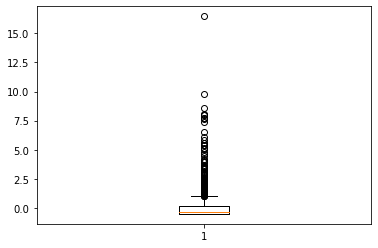

In [66]:
plt.boxplot(BTC_df_scaled[90:]['diff'])

In [41]:
from sklearn.model_selection import train_test_split
from sklearn import svm, metrics

In [68]:
def isNarrow(val):
    if abs(val) <= 1:
        return 'narrow'
    else:
        return 'wide'

In [76]:
BTC_df_scaled['diff'] = BTC_df_scaled['diff'].apply(isNarrow)

In [77]:
BTC_df_scaled['diff']

0       narrow
1       narrow
2       narrow
3       narrow
4       narrow
         ...  
2307    narrow
2308    narrow
2309    narrow
2310    narrow
2311    narrow
Name: diff, Length: 2312, dtype: object

In [78]:
label = BTC_df_scaled[90:]['diff']
data = BTC_df_scaled[90:][['bolingerdiff','dist','volume']]

In [79]:
data_train, data_test, label_train, label_test = train_test_split(data, label)

In [80]:
clf = svm.SVC()
clf.fit(data_train, label_train)
predict = clf.predict(data_test)

In [81]:
ac_score = metrics.accuracy_score(label_test, predict)
cl_report = metrics.classification_report(label_test, predict)

In [82]:
ac_score

0.9568345323741008

In [84]:
print(cl_report)

              precision    recall  f1-score   support

      narrow       0.97      0.99      0.98       509
        wide       0.83      0.62      0.71        47

    accuracy                           0.96       556
   macro avg       0.90      0.80      0.84       556
weighted avg       0.95      0.96      0.95       556



# 그리드 서치

In [85]:
import pandas as pd
from sklearn import model_selection, svm, metrics
#from sklearn.grid_search import GridSearchCV => error
from sklearn.model_selection import GridSearchCV

In [86]:
label = BTC_df_scaled[90:]['diff']
data = BTC_df_scaled[90:][['bolingerdiff','dist','volume']]
data_train, data_test, label_train, label_test = train_test_split(data, label)

In [87]:
params = [
    {"C": [1,10,100,1000], "kernel":["linear"]},
    {"C": [1,10,100,1000], "kernel":["rbf"], "gamma":[0.001, 0.0001]}
]

In [89]:
clf = GridSearchCV( svm.SVC(), params, n_jobs=-1 )
clf.fit(data_train, label_train)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']}])

In [91]:
clf.best_estimator_

SVC(C=1000, gamma=0.001)

In [94]:
pre = clf.predict(data_test)
ac_score = metrics.accuracy_score(pre, label_test)
print("정답률 =",ac_score)
cl_report = metrics.classification_report(label_test, pre)

정답률 = 0.9514388489208633


In [96]:
print(cl_report)

              precision    recall  f1-score   support

      narrow       0.95      1.00      0.97       503
        wide       0.96      0.51      0.67        53

    accuracy                           0.95       556
   macro avg       0.96      0.75      0.82       556
weighted avg       0.95      0.95      0.94       556

